In [ ]:
# From Classical Econometrics to Causal ML:
# Estimating Housing Price Effects of Macroprudential Policies with TARNet

## Research Question
**How do macroprudential policies (LTV, DSTI) causally affect housing prices, GDP, and credit gaps?**

### Treatment
- **LTV tightening** (binary or continuous intensity): 1 if LTV tightened, 0 otherwise

### Outcome
- **Housing price change** (YoY/QoQ percentage change)

### Controls (Covariates)
- GDP growth
- Credit gap
- Inflation
- Interest rates
- Exchange rates
- Lagged housing prices
- Household debt-to-income ratio
- Unemployment rate
- Regional indicators (if multi-region data)

### Advantages over SVAR
1. **Nonlinear relationships** - Neural networks capture complex interactions
2. **Heterogeneous effects** - Different impacts by region, credit conditions, household types
3. **Counterfactual predictions** - What would have happened without policy?
4. **Individual-level effects** - ITE vs aggregate ATE

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32)        │      2,784 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0 (Dense)          │ (None, 1)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1 (Dense)          │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,962 (19.38 KB)

 Trainable params: 4,962 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 1: Imports
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")



  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 2.7 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.9 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.1 MB/s  0:00:00 eta 0:00:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 3.0 MB/s  0:00:07m0:00:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [seaborn]9/11 [matplotlib]n]
TensorFlow version: 2.20.0
NumPy version: 2.2.6
Pandas version: 2.3.3


In [ ]:
# Step 2: Generate Synthetic Housing Market Data

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 6.1155 - y0_loss: 1.2472 - y1_loss: 4.8547 
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 3.4509 - y0_loss: 1.1430 - y1_loss: 2.2802
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 2.6343 - y0_loss: 1.0599 - y1_loss: 1.5899
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 2.2290 - y0_loss: 0.9763 - y1_loss: 1.2575
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 2.1073 - y0_loss: 0.9268 - y1_loss: 1.1660
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 2.0480 - y0_loss: 0.9396 - y1_loss: 1.1536
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 1.9856 - y0_loss: 0.9223 - y1_loss: 1.0811
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 1.9437 - y0_loss: 0.8968 - y1_loss: 1.0438
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9151 - y0_loss: 0.8841 - y1_loss: 1.0645
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 1.8780 - y0_l

In [16]:
# Ensure imports are available (run Cell 1 first if needed)
import numpy as np
import pandas as pd

def generate_synthetic_housing_data(
    n_samples: int = 3000,
    n_regions: int = 5,
    n_time_periods: int = None,
    seed: int = 42,
    treatment_rate: float = 0.35
) -> pd.DataFrame:
    """
    Generate realistic synthetic housing market data with clear causal patterns.
    
    Features:
    - Realistic macroeconomic variables with correlations
    - Heterogeneous treatment effects by region and credit conditions
    - Time-series structure for multi-period analysis
    - Clear causal relationships to validate model performance
    
    In production, replace this with your actual data loading:
    - Load from CSV/Excel
    - Query from database
    - Load from FRED, BIS, or central bank APIs
    """
    np.random.seed(seed)
    
    if n_time_periods is None:
        n_time_periods = n_samples // n_regions
    
    # Generate correlated macroeconomic features
    # Base economic conditions
    base_gdp = np.random.normal(2.5, 1.2, n_samples)
    base_credit_gap = np.random.normal(0, 2.5, n_samples)
    
    # Features with realistic correlations
    data = {
        'region': np.repeat(range(n_regions), n_time_periods),
        'time_period': np.tile(range(n_time_periods), n_regions),
        
        # Treatment: LTV tightening (higher probability when credit gap is high)
        # This creates realistic selection (not completely random)
        'credit_gap': base_credit_gap,
        'gdp_growth': base_gdp,
        
        # Correlated features
        'inflation': 0.3 * base_gdp + np.random.normal(2.0, 0.8, n_samples),
        'interest_rate': -0.5 * base_credit_gap + 0.4 * base_gdp + np.random.normal(3.0, 1.2, n_samples),
        'exchange_rate': -0.3 * base_gdp + np.random.normal(100, 4, n_samples),
        'household_debt_income': 0.4 * base_credit_gap + np.random.normal(150, 18, n_samples),
        'unemployment': -0.6 * base_gdp + np.random.normal(5.0, 1.3, n_samples),
        'lag_housing_price': 0.5 * base_gdp - 0.3 * base_credit_gap + np.random.normal(5.0, 2.5, n_samples),
    }
    
    df = pd.DataFrame(data)
    
    # Treatment assignment: higher probability when credit gap is high (realistic policy targeting)
    treatment_probs = 0.2 + 0.4 * (1 / (1 + np.exp(-df['credit_gap'] / 2)))  # Logistic function
    treatment_probs = np.clip(treatment_probs, 0.1, 0.8)
    df['treatment'] = np.random.binomial(1, treatment_probs, n_samples)
    
    # Generate outcomes with realistic causal relationships
    # Control outcome (y0): housing price change without LTV tightening
    # Positive: GDP growth, credit gap, lag prices
    # Negative: interest rates (higher rates reduce demand)
    df['y0'] = (
        0.35 * df['gdp_growth'] +
        0.25 * df['credit_gap'] +
        -0.5 * df['interest_rate'] +
        0.12 * df['inflation'] +
        0.18 * df['lag_housing_price'] +
        0.08 * df['exchange_rate'] / 10 +  # Scaled for similar magnitude
        np.random.normal(0, 1.8, n_samples)
    )
    
    # Treatment effect: heterogeneous and realistic
    # Base ATE: -1.5 (LTV tightening reduces price growth)
    # Stronger effect when credit gap is high (policy more effective)
    # Region-specific effects (some regions more sensitive)
    # Interaction with GDP (stronger effect in booming economies)
    treatment_effect = (
        -1.5 +  # Average treatment effect (negative: reduces price growth)
        -0.35 * df['credit_gap'] +  # Larger effect when credit gap is high
        0.15 * (df['gdp_growth'] - 2.5) +  # Stronger effect in booming economies
        0.25 * np.sin(df['region'] * np.pi / n_regions) +  # Region-specific pattern
        0.1 * df['interest_rate'] / 3  # Interaction with interest rates
    )
    
    # Treated outcome (y1): control outcome + treatment effect
    df['y1'] = df['y0'] + treatment_effect
    
    # Observed outcome: what we actually see (fundamental problem of causal inference)
    df['y_observed'] = np.where(df['treatment'] == 1, df['y1'], df['y0'])
    
    # Store true treatment effect for evaluation
    df['true_treatment_effect'] = treatment_effect
    
    # Add some noise to observed outcomes (measurement error)
    df['y_observed'] = df['y_observed'] + np.random.normal(0, 0.2, n_samples)
    
    return df

# Generate synthetic data
print("="*70)
print("GENERATING SYNTHETIC HOUSING MARKET DATA")
print("="*70)
print("\nGenerating realistic housing market data with clear causal patterns...")
df = generate_synthetic_housing_data(n_samples=3000, n_regions=5, treatment_rate=0.35)

print(f"\n✅ Data Generated Successfully!")
print(f"\nData shape: {df.shape}")
print(f"Features: {df.shape[1]} columns, {df.shape[0]} observations")
print(f"\nTreatment distribution:")
print(df['treatment'].value_counts())
print(f"Treatment rate: {df['treatment'].mean():.2%}")
print(f"\nData summary:")
print(df[['gdp_growth', 'credit_gap', 'inflation', 'interest_rate', 
          'y_observed', 'y0', 'y1', 'treatment']].describe())


GENERATING SYNTHETIC HOUSING MARKET DATA

Generating realistic housing market data with clear causal patterns...

✅ Data Generated Successfully!

Data shape: (3000, 15)
Features: 15 columns, 3000 observations

Treatment distribution:
treatment
0    1842
1    1158
Name: count, dtype: int64
Treatment rate: 38.60%

Data summary:
        gdp_growth   credit_gap    inflation  interest_rate   y_observed  \
count  3000.000000  3000.000000  3000.000000    3000.000000  3000.000000   
mean      2.538401    -0.095609     2.764028       4.037910     0.523617   
std       1.184169     2.522065     0.897472       1.814203     2.252950   
min      -1.389521    -7.941760    -0.847836      -1.877404    -6.160520   
25%       1.746951    -1.781404     2.165161       2.825963    -1.012865   
50%       2.529238    -0.055724     2.761231       4.024725     0.463407   
75%       3.308309     1.596661     3.362139       5.167314     2.032657   
max       7.211485     8.107732     5.799969      10.821665     

### Data Exploration: Understanding the Synthetic Dataset


In [17]:
# Explore the data structure and key patterns
print("="*70)
print("DATA EXPLORATION & INSIGHTS")
print("="*70)

# Basic statistics
print("\n1. BASIC STATISTICS")
print("-"*70)
print(f"Total samples: {len(df):,}")
print(f"Treated samples: {df['treatment'].sum():,} ({df['treatment'].mean():.1%})")
print(f"Control samples: {(df['treatment'] == 0).sum():,} ({(df['treatment'] == 0).mean():.1%})")
print(f"Number of regions: {df['region'].nunique()}")
print(f"Time periods: {df['time_period'].nunique()}")

# True ATE (we know this because we generated the data)
print("\n2. TRUE TREATMENT EFFECT (Known from data generation)")
print("-"*70)
true_ate = df['true_treatment_effect'].mean()
print(f"True Average Treatment Effect (ATE): {true_ate:.3f}")
print(f"True ATE by treatment status:")
print(f"  - For treated units: {df[df['treatment']==1]['true_treatment_effect'].mean():.3f}")
print(f"  - For control units: {df[df['treatment']==0]['true_treatment_effect'].mean():.3f}")

# Naive comparison (what we'd see without causal ML - BIASED!)
print("\n3. NAIVE COMPARISON (Biased - For Reference Only)")
print("-"*70)
naive_diff = df[df['treatment']==1]['y_observed'].mean() - df[df['treatment']==0]['y_observed'].mean()
print(f"Naive difference (Treated - Control): {naive_diff:.3f}")
print(f"This is BIASED because treated and control groups differ in covariates!")
print(f"True ATE: {true_ate:.3f}")
print(f"Bias: {naive_diff - true_ate:.3f}")

# Heterogeneity by subgroups
print("\n4. HETEROGENEITY ANALYSIS")
print("-"*70)
print("True treatment effects by credit gap:")
high_credit = df['credit_gap'] > df['credit_gap'].median()
print(f"  - High credit gap: {df[high_credit]['true_treatment_effect'].mean():.3f}")
print(f"  - Low credit gap: {df[~high_credit]['true_treatment_effect'].mean():.3f}")

print("\nTrue treatment effects by GDP growth:")
high_gdp = df['gdp_growth'] > df['gdp_growth'].median()
print(f"  - High GDP growth: {df[high_gdp]['true_treatment_effect'].mean():.3f}")
print(f"  - Low GDP growth: {df[~high_gdp]['true_treatment_effect'].mean():.3f}")

print("\nTrue treatment effects by region:")
for region in sorted(df['region'].unique()):
    region_effect = df[df['region'] == region]['true_treatment_effect'].mean()
    print(f"  - Region {region}: {region_effect:.3f}")

# Feature correlations with treatment
print("\n5. FEATURE CORRELATIONS WITH TREATMENT")
print("-"*70)
feature_cols = ['gdp_growth', 'credit_gap', 'inflation', 'interest_rate', 
                'household_debt_income', 'unemployment', 'lag_housing_price']
correlations = df[feature_cols + ['treatment']].corr()['treatment'][:-1]
print("Correlation of features with treatment assignment:")
for feature, corr in correlations.items():
    print(f"  - {feature:20s}: {corr:6.3f}")
print("\n⚠️  Note: Non-zero correlations indicate selection bias (confounding)")


DATA EXPLORATION & INSIGHTS

1. BASIC STATISTICS
----------------------------------------------------------------------
Total samples: 3,000
Treated samples: 1,158 (38.6%)
Control samples: 1,842 (61.4%)
Number of regions: 5
Time periods: 600

2. TRUE TREATMENT EFFECT (Known from data generation)
----------------------------------------------------------------------
True Average Treatment Effect (ATE): -1.172
True ATE by treatment status:
  - For treated units: -1.378
  - For control units: -1.043

3. NAIVE COMPARISON (Biased - For Reference Only)
----------------------------------------------------------------------
Naive difference (Treated - Control): -1.005
This is BIASED because treated and control groups differ in covariates!
True ATE: -1.172
Bias: 0.167

4. HETEROGENEITY ANALYSIS
----------------------------------------------------------------------
True treatment effects by credit gap:
  - High credit gap: -1.911
  - Low credit gap: -0.433

True treatment effects by GDP growth:


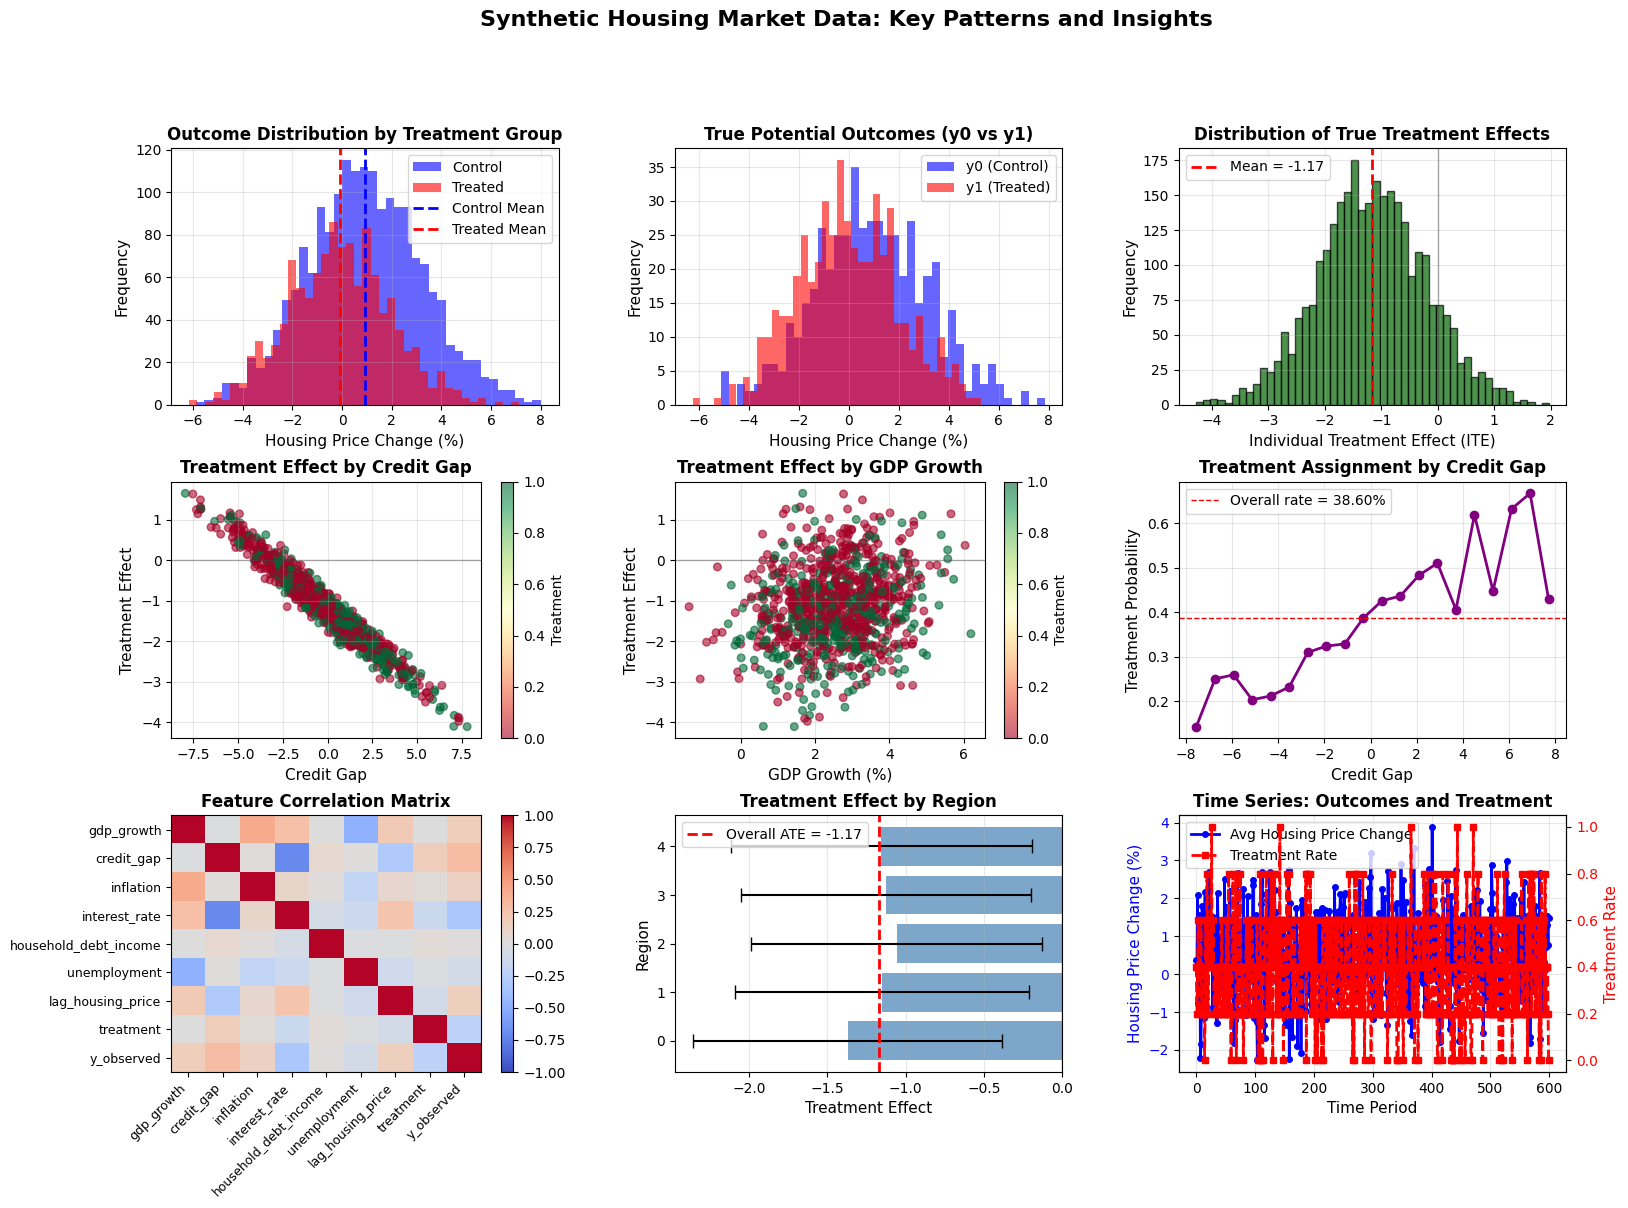


✅ Data exploration complete! Key insights:
   • Treatment effects vary by credit gap and GDP growth (heterogeneity)
   • Treatment assignment is correlated with credit gap (selection bias)
   • True ATE is negative: LTV tightening reduces price growth
   • Regions show different treatment effects (CATE)


In [18]:
# Visualize data patterns and distributions
# Ensure imports are available
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Outcome distributions by treatment group
ax1 = fig.add_subplot(gs[0, 0])
df[df['treatment']==0]['y_observed'].hist(bins=40, alpha=0.6, label='Control', color='blue', ax=ax1)
df[df['treatment']==1]['y_observed'].hist(bins=40, alpha=0.6, label='Treated', color='red', ax=ax1)
ax1.axvline(df[df['treatment']==0]['y_observed'].mean(), color='blue', linestyle='--', linewidth=2, label='Control Mean')
ax1.axvline(df[df['treatment']==1]['y_observed'].mean(), color='red', linestyle='--', linewidth=2, label='Treated Mean')
ax1.set_xlabel('Housing Price Change (%)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Outcome Distribution by Treatment Group', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. True potential outcomes
ax2 = fig.add_subplot(gs[0, 1])
df[df['treatment']==0].sample(500)['y0'].hist(bins=40, alpha=0.6, label='y0 (Control)', color='blue', ax=ax2)
df[df['treatment']==1].sample(500)['y1'].hist(bins=40, alpha=0.6, label='y1 (Treated)', color='red', ax=ax2)
ax2.set_xlabel('Housing Price Change (%)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('True Potential Outcomes (y0 vs y1)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Treatment effect distribution
ax3 = fig.add_subplot(gs[0, 2])
df['true_treatment_effect'].hist(bins=50, alpha=0.7, color='darkgreen', edgecolor='black', ax=ax3)
ax3.axvline(df['true_treatment_effect'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {df["true_treatment_effect"].mean():.2f}')
ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax3.set_xlabel('Individual Treatment Effect (ITE)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution of True Treatment Effects', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Treatment effect by credit gap
ax4 = fig.add_subplot(gs[1, 0])
df_plot = df.sample(min(1000, len(df)))
scatter = ax4.scatter(df_plot['credit_gap'], df_plot['true_treatment_effect'], 
                     c=df_plot['treatment'], cmap='RdYlGn', alpha=0.6, s=30)
ax4.set_xlabel('Credit Gap', fontsize=11)
ax4.set_ylabel('Treatment Effect', fontsize=11)
ax4.set_title('Treatment Effect by Credit Gap', fontsize=12, fontweight='bold')
ax4.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Treatment')

# 5. Treatment effect by GDP growth
ax5 = fig.add_subplot(gs[1, 1])
scatter = ax5.scatter(df_plot['gdp_growth'], df_plot['true_treatment_effect'], 
                     c=df_plot['treatment'], cmap='RdYlGn', alpha=0.6, s=30)
ax5.set_xlabel('GDP Growth (%)', fontsize=11)
ax5.set_ylabel('Treatment Effect', fontsize=11)
ax5.set_title('Treatment Effect by GDP Growth', fontsize=12, fontweight='bold')
ax5.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Treatment')

# 6. Treatment assignment probability by credit gap
ax6 = fig.add_subplot(gs[1, 2])
df['credit_bin'] = pd.cut(df['credit_gap'], bins=20)
treatment_rate_by_credit = df.groupby('credit_bin')['treatment'].mean()
credit_mid = [interval.mid for interval in treatment_rate_by_credit.index]
ax6.plot(credit_mid, treatment_rate_by_credit.values, 'o-', linewidth=2, markersize=6, color='purple')
ax6.set_xlabel('Credit Gap', fontsize=11)
ax6.set_ylabel('Treatment Probability', fontsize=11)
ax6.set_title('Treatment Assignment by Credit Gap', fontsize=12, fontweight='bold')
ax6.axhline(df['treatment'].mean(), color='red', linestyle='--', linewidth=1, 
            label=f'Overall rate = {df["treatment"].mean():.2%}')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Feature correlation heatmap
ax7 = fig.add_subplot(gs[2, 0])
corr_features = feature_cols + ['treatment', 'y_observed']
corr_matrix = df[corr_features].corr()
im = ax7.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax7.set_xticks(range(len(corr_features)))
ax7.set_yticks(range(len(corr_features)))
ax7.set_xticklabels(corr_features, rotation=45, ha='right', fontsize=9)
ax7.set_yticklabels(corr_features, fontsize=9)
ax7.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax7)

# 8. Treatment effect by region
ax8 = fig.add_subplot(gs[2, 1])
region_effects = df.groupby('region')['true_treatment_effect'].agg(['mean', 'std'])
regions = region_effects.index
ax8.barh(regions, region_effects['mean'], xerr=region_effects['std'], 
         alpha=0.7, color='steelblue', capsize=5)
ax8.axvline(df['true_treatment_effect'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Overall ATE = {df["true_treatment_effect"].mean():.2f}')
ax8.set_xlabel('Treatment Effect', fontsize=11)
ax8.set_ylabel('Region', fontsize=11)
ax8.set_title('Treatment Effect by Region', fontsize=12, fontweight='bold')
ax8.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax8.legend()
ax8.grid(True, alpha=0.3, axis='x')

# 9. Time series of outcomes
ax9 = fig.add_subplot(gs[2, 2])
if 'time_period' in df.columns:
    time_series = df.groupby('time_period').agg({
        'y_observed': 'mean',
        'treatment': 'mean'
    })
    ax9_twin = ax9.twinx()
    line1 = ax9.plot(time_series.index, time_series['y_observed'], 
                     'o-', color='blue', linewidth=2, label='Avg Housing Price Change', markersize=4)
    line2 = ax9_twin.plot(time_series.index, time_series['treatment'], 
                          's--', color='red', linewidth=2, label='Treatment Rate', markersize=4)
    ax9.set_xlabel('Time Period', fontsize=11)
    ax9.set_ylabel('Housing Price Change (%)', fontsize=11, color='blue')
    ax9_twin.set_ylabel('Treatment Rate', fontsize=11, color='red')
    ax9.set_title('Time Series: Outcomes and Treatment', fontsize=12, fontweight='bold')
    ax9.tick_params(axis='y', labelcolor='blue')
    ax9_twin.tick_params(axis='y', labelcolor='red')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax9.legend(lines, labels, loc='upper left')
    ax9.grid(True, alpha=0.3)

plt.suptitle('Synthetic Housing Market Data: Key Patterns and Insights', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Data exploration complete! Key insights:")
print("   • Treatment effects vary by credit gap and GDP growth (heterogeneity)")
print("   • Treatment assignment is correlated with credit gap (selection bias)")
print("   • True ATE is negative: LTV tightening reduces price growth")
print("   • Regions show different treatment effects (CATE)")


### Split Data into Training and Test Sets


In [19]:
# Verify we have the data ready for preprocessing
print("="*70)
print("DATA SUMMARY FOR MODEL TRAINING")
print("="*70)

print(f"\n✅ Dataset ready:")
print(f"   Total samples: {len(df):,}")
print(f"   Features available: {len([col for col in df.columns if col not in ['y0', 'y1', 'y_observed', 'true_treatment_effect', 'credit_bin']])}")

print(f"\n📊 Outcome variables:")
print(f"   y_observed: {df['y_observed'].min():.2f} to {df['y_observed'].max():.2f} (mean: {df['y_observed'].mean():.2f})")
print(f"   y0 (control potential outcome): {df['y0'].min():.2f} to {df['y0'].max():.2f} (mean: {df['y0'].mean():.2f})")
print(f"   y1 (treated potential outcome): {df['y1'].min():.2f} to {df['y1'].max():.2f} (mean: {df['y1'].mean():.2f})")

print(f"\n🎯 Treatment:")
print(f"   Treatment rate: {df['treatment'].mean():.1%}")
print(f"   True ATE: {df['true_treatment_effect'].mean():.3f}")
print(f"   True ATE std: {df['true_treatment_effect'].std():.3f}")

print(f"\n📈 Features:")
feature_cols_to_use = ['gdp_growth', 'credit_gap', 'inflation', 'interest_rate',
                       'exchange_rate', 'household_debt_income', 'unemployment', 'lag_housing_price']
print(f"   Will use {len(feature_cols_to_use)} features: {', '.join(feature_cols_to_use)}")

print(f"\n💡 Next step: Preprocess and split into train/val/test sets...")


DATA SUMMARY FOR MODEL TRAINING

✅ Dataset ready:
   Total samples: 3,000
   Features available: 11

📊 Outcome variables:
   y_observed: -6.16 to 8.01 (mean: 0.52)
   y0 (control potential outcome): -5.85 to 8.43 (mean: 1.06)
   y1 (treated potential outcome): -6.24 to 7.19 (mean: -0.11)

🎯 Treatment:
   Treatment rate: 38.6%
   True ATE: -1.172
   True ATE std: 0.953

📈 Features:
   Will use 8 features: gdp_growth, credit_gap, inflation, interest_rate, exchange_rate, household_debt_income, unemployment, lag_housing_price

💡 Next step: Preprocess and split into train/val/test sets...


In [ ]:
# Export synthetic data to CSV for future use or sharing
import os

# Create a data export directory if it doesn't exist
export_dir = 'data_exports'
os.makedirs(export_dir, exist_ok=True)

# Export full dataset
csv_filename = os.path.join(export_dir, 'synthetic_housing_market_data.csv')
df.to_csv(csv_filename, index=False)
print(f"✅ Full dataset exported to: {csv_filename}")
print(f"   Shape: {df.shape}")

# Export with only selected features (for model training)
feature_cols_export = ['gdp_growth', 'credit_gap', 'inflation', 'interest_rate',
                       'exchange_rate', 'household_debt_income', 'unemployment', 
                       'lag_housing_price', 'treatment', 'y_observed']
df_export = df[feature_cols_export + ['y0', 'y1', 'true_treatment_effect']].copy()
export_filename = os.path.join(export_dir, 'synthetic_housing_data_model_ready.csv')
df_export.to_csv(export_filename, index=False)
print(f"\n✅ Model-ready dataset exported to: {export_filename}")
print(f"   Shape: {df_export.shape}")
print(f"   Columns: {', '.join(df_export.columns)}")

# Export train/test splits if data is already preprocessed
if 'data' in globals():
    print("\n📊 Exporting train/val/test splits...")
    
    # Get original indices (approximate - since train_test_split shuffles)
    # For a more accurate mapping, you'd need to track indices during splitting
    train_size = data['X_train'].shape[0]
    val_size = data['X_val'].shape[0]
    test_size = data['X_test'].shape[0]
    
    # Export summary
    split_summary = pd.DataFrame({
        'split': ['train', 'val', 'test'],
        'n_samples': [train_size, val_size, test_size],
        'treatment_rate': [
            data['T_train'].mean(),
            data['T_val'].mean(),
            data['T_test'].mean()
        ]
    })
    split_filename = os.path.join(export_dir, 'data_splits_summary.csv')
    split_summary.to_csv(split_filename, index=False)
    print(f"✅ Split summary exported to: {split_filename}")

print(f"\n📁 All exports saved in: {os.path.abspath(export_dir)}/")


In [ ]:
# Export training, validation, and test splits to CSV files
# This allows you to replicate the data structure with real data later

import os
import pandas as pd

# Create export directory
export_dir = 'data_exports'
os.makedirs(export_dir, exist_ok=True)

print("="*70)
print("EXPORTING TRAIN/VAL/TEST SPLITS TO CSV")
print("="*70)

# Get feature names
feature_names = data['feature_names']

# Helper function to create DataFrame from split
def create_split_df(X, T, Y, feature_names, split_name):
    """Create a DataFrame from X, T, Y arrays with proper column names"""
    df = pd.DataFrame(X, columns=feature_names)
    df['treatment'] = T
    df['outcome'] = Y.flatten() if Y.ndim > 1 else Y
    return df

# Export training set
train_df = create_split_df(
    data['X_train'], 
    data['T_train'], 
    data['Y_train'],
    feature_names,
    'train'
)
train_filename = os.path.join(export_dir, 'train_data.csv')
train_df.to_csv(train_filename, index=False)
print(f"\n✅ Training set exported: {train_filename}")
print(f"   Shape: {train_df.shape}")
print(f"   Treatment rate: {train_df['treatment'].mean():.2%}")
print(f"   Columns: {', '.join(train_df.columns.tolist())}")

# Export validation set
val_df = create_split_df(
    data['X_val'], 
    data['T_val'], 
    data['Y_val'],
    feature_names,
    'val'
)
val_filename = os.path.join(export_dir, 'val_data.csv')
val_df.to_csv(val_filename, index=False)
print(f"\n✅ Validation set exported: {val_filename}")
print(f"   Shape: {val_df.shape}")
print(f"   Treatment rate: {val_df['treatment'].mean():.2%}")

# Export test set
test_df = create_split_df(
    data['X_test'], 
    data['T_test'], 
    data['Y_test'],
    feature_names,
    'test'
)
test_filename = os.path.join(export_dir, 'test_data.csv')
test_df.to_csv(test_filename, index=False)
print(f"\n✅ Test set exported: {test_filename}")
print(f"   Shape: {test_df.shape}")
print(f"   Treatment rate: {test_df['treatment'].mean():.2%}")

# Export a summary file with metadata
summary_data = {
    'split': ['train', 'val', 'test'],
    'n_samples': [
        len(train_df),
        len(val_df),
        len(test_df)
    ],
    'treatment_rate': [
        train_df['treatment'].mean(),
        val_df['treatment'].mean(),
        test_df['treatment'].mean()
    ],
    'outcome_mean': [
        train_df['outcome'].mean(),
        val_df['outcome'].mean(),
        test_df['outcome'].mean()
    ],
    'outcome_std': [
        train_df['outcome'].std(),
        val_df['outcome'].std(),
        test_df['outcome'].std()
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_filename = os.path.join(export_dir, 'data_splits_summary.csv')
summary_df.to_csv(summary_filename, index=False)
print(f"\n✅ Summary exported: {summary_filename}")
print(summary_df.to_string(index=False))

# Export feature names for reference
feature_info = pd.DataFrame({
    'feature_name': feature_names,
    'feature_index': range(len(feature_names))
})
feature_info_filename = os.path.join(export_dir, 'feature_names.csv')
feature_info.to_csv(feature_info_filename, index=False)
print(f"\n✅ Feature names exported: {feature_info_filename}")

# Export a README with instructions for loading
readme_content = f"""# Data Export Information

## Files Exported

1. **train_data.csv** - Training set ({len(train_df):,} samples)
2. **val_data.csv** - Validation set ({len(val_df):,} samples)
3. **test_data.csv** - Test set ({len(test_df):,} samples)
4. **data_splits_summary.csv** - Summary statistics for each split
5. **feature_names.csv** - Feature column names and indices

## Column Structure

Each CSV file contains:
- **Feature columns**: {', '.join(feature_names)}
- **treatment**: Binary treatment indicator (0 = control, 1 = treated)
- **outcome**: Observed outcome variable

## How to Load with Real Data

```python
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load your real data
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

# Extract features, treatment, and outcome
feature_cols = {feature_names}

X_train = train_df[feature_cols].values
T_train = train_df['treatment'].values
Y_train = train_df['outcome'].values.reshape(-1, 1)

X_val = val_df[feature_cols].values
T_val = val_df['treatment'].values
Y_val = val_df['outcome'].values.reshape(-1, 1)

X_test = test_df[feature_cols].values
T_test = test_df['treatment'].values
Y_test = test_df['outcome'].values.reshape(-1, 1)

# Note: These data are already normalized (StandardScaler was applied)
# If loading new raw data, you'll need to:
# 1. Normalize using StandardScaler
# 2. Ensure same feature order as feature_names.csv
```

## Important Notes

- All features are **normalized** (StandardScaler applied)
- Treatment is binary: 0 = control, 1 = treated
- Outcome is continuous (housing price change %)
- Data splits maintain stratification by treatment

## Replicating with Real Data

To use this structure with your real data:

1. Prepare your data with the same feature columns
2. Ensure you have a binary treatment column (0/1)
3. Ensure you have an outcome column
4. Normalize features using StandardScaler
5. Split into train/val/test maintaining treatment stratification
6. Save in the same CSV format

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

readme_filename = os.path.join(export_dir, 'README.md')
with open(readme_filename, 'w') as f:
    f.write(readme_content)
print(f"\n✅ README exported: {readme_filename}")

print("\n" + "="*70)
print(f"📁 All files saved in: {os.path.abspath(export_dir)}/")
print("="*70)
print("\n💡 You can now use these CSV files to replicate the structure")
print("   with your real housing market data!")


In [61]:
def preprocess_data(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    treatment_col: str = 'treatment',
    test_size: float = 0.2,
    val_size: float = 0.1
) -> Dict[str, np.ndarray]:
    """
    Preprocess data for TARNet:
    1. Handle missing values
    2. Normalize features (critical for neural networks)
    3. Split into train/val/test
    4. Separate treatment and control groups
    """
    # Copy to avoid modifying original
    df_processed = df.copy()
    
    # Handle missing values
    # Forward fill for time-series, median imputation for others
    for col in feature_cols:
        if df_processed[col].isnull().sum() > 0:
            if 'lag' in col.lower() or 'time' in col.lower():
                df_processed[col] = df_processed[col].fillna(method='ffill')
            else:
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # Extract features and outcomes
    X = df_processed[feature_cols].values
    T = df_processed[treatment_col].values
    Y = df_processed[target_col].values.reshape(-1, 1)
    
    # Normalize features (critical for neural networks)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    # First split: train + val vs test
    X_temp, X_test, T_temp, T_test, Y_temp, Y_test = train_test_split(
        X_scaled, T, Y, test_size=test_size, random_state=42, stratify=T
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, T_train, T_val, Y_train, Y_val = train_test_split(
        X_temp, T_temp, Y_temp, test_size=val_size_adjusted, random_state=42, stratify=T_temp
    )
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'T_train': T_train, 'T_val': T_val, 'T_test': T_test,
        'Y_train': Y_train, 'Y_val': Y_val, 'Y_test': Y_test,
        'scaler': scaler,
        'feature_names': feature_cols
    }

# Define features (covariates)
feature_cols = [
    'gdp_growth', 'credit_gap', 'inflation', 'interest_rate',
    'exchange_rate', 'household_debt_income', 'unemployment', 'lag_housing_price'
]

# Preprocess data
data = preprocess_data(
    df,
    feature_cols=feature_cols,
    target_col='y_observed',
    treatment_col='treatment'
)

print(f"Training set: {data['X_train'].shape[0]} samples")
print(f"Validation set: {data['X_val'].shape[0]} samples")
print(f"Test set: {data['X_test'].shape[0]} samples")
print(f"\nFeature dimensions: {data['X_train'].shape[1]}")
print(f"Treatment rate in training: {data['T_train'].mean():.2%}")


Training set: 2100 samples
Validation set: 300 samples
Test set: 600 samples

Feature dimensions: 8
Treatment rate in training: 38.57%


In [62]:
# Export training, validation, and test splits to CSV files
# This allows you to replicate the data structure with real data later

import os
import pandas as pd

# Create export directory
export_dir = 'data_exports'
os.makedirs(export_dir, exist_ok=True)

print("="*70)
print("EXPORTING TRAIN/VAL/TEST SPLITS TO CSV")
print("="*70)

# Get feature names
feature_names = data['feature_names']

# Helper function to create DataFrame from split
def create_split_df(X, T, Y, feature_names, split_name):
    """Create a DataFrame from X, T, Y arrays with proper column names"""
    df = pd.DataFrame(X, columns=feature_names)
    df['treatment'] = T
    df['outcome'] = Y.flatten() if Y.ndim > 1 else Y
    return df

# Export training set
train_df = create_split_df(
    data['X_train'], 
    data['T_train'], 
    data['Y_train'],
    feature_names,
    'train'
)
train_filename = os.path.join(export_dir, 'train_data.csv')
train_df.to_csv(train_filename, index=False)
print(f"\n✅ Training set exported: {train_filename}")
print(f"   Shape: {train_df.shape}")
print(f"   Treatment rate: {train_df['treatment'].mean():.2%}")
print(f"   Columns: {', '.join(train_df.columns.tolist())}")

# Export validation set
val_df = create_split_df(
    data['X_val'], 
    data['T_val'], 
    data['Y_val'],
    feature_names,
    'val'
)
val_filename = os.path.join(export_dir, 'val_data.csv')
val_df.to_csv(val_filename, index=False)
print(f"\n✅ Validation set exported: {val_filename}")
print(f"   Shape: {val_df.shape}")
print(f"   Treatment rate: {val_df['treatment'].mean():.2%}")

# Export test set
test_df = create_split_df(
    data['X_test'], 
    data['T_test'], 
    data['Y_test'],
    feature_names,
    'test'
)
test_filename = os.path.join(export_dir, 'test_data.csv')
test_df.to_csv(test_filename, index=False)
print(f"\n✅ Test set exported: {test_filename}")
print(f"   Shape: {test_df.shape}")
print(f"   Treatment rate: {test_df['treatment'].mean():.2%}")

# Export a summary file with metadata
summary_data = {
    'split': ['train', 'val', 'test'],
    'n_samples': [
        len(train_df),
        len(val_df),
        len(test_df)
    ],
    'treatment_rate': [
        train_df['treatment'].mean(),
        val_df['treatment'].mean(),
        test_df['treatment'].mean()
    ],
    'outcome_mean': [
        train_df['outcome'].mean(),
        val_df['outcome'].mean(),
        test_df['outcome'].mean()
    ],
    'outcome_std': [
        train_df['outcome'].std(),
        val_df['outcome'].std(),
        test_df['outcome'].std()
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_filename = os.path.join(export_dir, 'data_splits_summary.csv')
summary_df.to_csv(summary_filename, index=False)
print(f"\n✅ Summary exported: {summary_filename}")
print(summary_df.to_string(index=False))

# Export feature names for reference
feature_info = pd.DataFrame({
    'feature_name': feature_names,
    'feature_index': range(len(feature_names))
})
feature_info_filename = os.path.join(export_dir, 'feature_names.csv')
feature_info.to_csv(feature_info_filename, index=False)
print(f"\n✅ Feature names exported: {feature_info_filename}")

# Export a README with instructions for loading
readme_content = f"""# Data Export Information

## Files Exported

1. **train_data.csv** - Training set ({len(train_df):,} samples)
2. **val_data.csv** - Validation set ({len(val_df):,} samples)
3. **test_data.csv** - Test set ({len(test_df):,} samples)
4. **data_splits_summary.csv** - Summary statistics for each split
5. **feature_names.csv** - Feature column names and indices

## Column Structure

Each CSV file contains:
- **Feature columns**: {', '.join(feature_names)}
- **treatment**: Binary treatment indicator (0 = control, 1 = treated)
- **outcome**: Observed outcome variable

## How to Load with Real Data

```python
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load your real data
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

# Extract features, treatment, and outcome
feature_cols = {feature_names}

X_train = train_df[feature_cols].values
T_train = train_df['treatment'].values
Y_train = train_df['outcome'].values.reshape(-1, 1)

X_val = val_df[feature_cols].values
T_val = val_df['treatment'].values
Y_val = val_df['outcome'].values.reshape(-1, 1)

X_test = test_df[feature_cols].values
T_test = test_df['treatment'].values
Y_test = test_df['outcome'].values.reshape(-1, 1)

# Note: These data are already normalized (StandardScaler was applied)
# If loading new raw data, you'll need to:
# 1. Normalize using StandardScaler
# 2. Ensure same feature order as feature_names.csv
```

## Important Notes

- All features are **normalized** (StandardScaler applied)
- Treatment is binary: 0 = control, 1 = treated
- Outcome is continuous (housing price change %)
- Data splits maintain stratification by treatment

## Replicating with Real Data

To use this structure with your real data:

1. Prepare your data with the same feature columns
2. Ensure you have a binary treatment column (0/1)
3. Ensure you have an outcome column
4. Normalize features using StandardScaler
5. Split into train/val/test maintaining treatment stratification
6. Save in the same CSV format

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

readme_filename = os.path.join(export_dir, 'README.md')
with open(readme_filename, 'w') as f:
    f.write(readme_content)
print(f"\n✅ README exported: {readme_filename}")

print("\n" + "="*70)
print(f"📁 All files saved in: {os.path.abspath(export_dir)}/")
print("="*70)
print("\n💡 You can now use these CSV files to replicate the structure")
print("   with your real housing market data!")


EXPORTING TRAIN/VAL/TEST SPLITS TO CSV

✅ Training set exported: data_exports/train_data.csv
   Shape: (2100, 10)
   Treatment rate: 38.57%
   Columns: gdp_growth, credit_gap, inflation, interest_rate, exchange_rate, household_debt_income, unemployment, lag_housing_price, treatment, outcome

✅ Validation set exported: data_exports/val_data.csv
   Shape: (300, 10)
   Treatment rate: 38.67%

✅ Test set exported: data_exports/test_data.csv
   Shape: (600, 10)
   Treatment rate: 38.67%

✅ Summary exported: data_exports/data_splits_summary.csv
split  n_samples  treatment_rate  outcome_mean  outcome_std
train       2100        0.385714      0.532422     2.254949
  val        300        0.386667      0.624700     2.443984
 test        600        0.386667      0.442259     2.145048

✅ Feature names exported: data_exports/feature_names.csv

✅ README exported: data_exports/README.md

📁 All files saved in: /Users/dimaso/Documents/[1] Dimaso/[3] Python/[4] TrainingTensorFlow/[1]Basic/data_exports/

# Step 3: Enhanced TARNet Implementation


In [21]:
def build_representation_network(
    input_dim: int,
    hidden_units: List[int] = [128, 64, 32],
    dropout_rate: float = 0.2,
    l2_reg: float = 0.001
) -> tf.keras.Model:
    """
    Shared representation network that learns features from covariates.
    This is where the model learns to balance treatment and control groups.
    """
    inputs = Input(shape=(input_dim,), name='covariates')
    x = inputs
    
    for i, units in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name=f'representation_dense_{i}'
        )(x)
        x = layers.BatchNormalization(name=f'batch_norm_{i}')(x)
        x = layers.Dropout(dropout_rate, name=f'dropout_{i}')(x)
    
    representation = layers.Dense(
        hidden_units[-1],
        activation='relu',
        name='final_representation'
    )(x)
    
    return Model(inputs=inputs, outputs=representation, name='representation_network')


def build_tarnet(
    input_dim: int,
    representation_units: List[int] = [128, 64, 32],
    outcome_units: List[int] = [32, 16],
    dropout_rate: float = 0.2,
    l2_reg: float = 0.001
) -> tf.keras.Model:
    """
    TARNet: Treatment-Agnostic Representation Network
    
    Architecture:
    - Shared representation network (learns balanced features)
    - Two outcome heads:
        * y0: Outcome under control (no treatment)
        * y1: Outcome under treatment
    
    The key insight: both heads share the same representation,
    allowing the model to generalize counterfactual predictions.
    """
    # Input layer
    inputs = Input(shape=(input_dim,), name='covariates')
    
    # Shared representation
    representation_net = build_representation_network(
        input_dim, representation_units, dropout_rate, l2_reg
    )
    representation = representation_net(inputs)
    
    # Outcome head for control (t=0): no treatment
    y0 = representation
    for i, units in enumerate(outcome_units):
        y0 = layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name=f'y0_dense_{i}'
        )(y0)
        y0 = layers.Dropout(dropout_rate, name=f'y0_dropout_{i}')(y0)
    y0 = layers.Dense(1, name='y0', activation=None)(y0)  # No activation for regression
    
    # Outcome head for treatment (t=1): with treatment
    y1 = representation  # Same representation!
    for i, units in enumerate(outcome_units):
        y1 = layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name=f'y1_dense_{i}'
        )(y1)
        y1 = layers.Dropout(dropout_rate, name=f'y1_dropout_{i}')(y1)
    y1 = layers.Dense(1, name='y1', activation=None)(y1)  # No activation for regression
    
    model = Model(inputs=inputs, outputs=[y0, y1], name='TARNet')
    return model

# Build model
input_dim = data['X_train'].shape[1]
print(f"Building TARNet with input dimension: {input_dim}")

tarnet = build_tarnet(
    input_dim=input_dim,
    representation_units=[128, 64, 32],
    outcome_units=[32, 16],
    dropout_rate=0.2,
    l2_reg=0.001
)

# Compile model
tarnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={'y0': 'mse', 'y1': 'mse'},
    loss_weights={'y0': 1.0, 'y1': 1.0},
    metrics={'y0': ['mae'], 'y1': ['mae']}
)

print("\nModel architecture:")
tarnet.summary()


Building TARNet with input dimension: 8

Model architecture:


Model: "TARNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ covariates          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ representation_net… │ (None, 32)        │     13,440 │ covariates[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0_dense_0 (Dense)  │ (None, 32)        │      1,056 │ representation_n… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_dense_0 (Dense)  │ (None, 32)        │      1,056 │ representation_n… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0_dropout_0        │ (None, 32)        │          0 │ y0_dense_0[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_dropout_0        │ (None, 32)        │          0 │ y1_dense_0[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0_dense_1 (Dense)  │ (None, 16)        │        528 │ y0_dropout_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_dense_1 (Dense)  │ (None, 16)        │        528 │ y1_dropout_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0_dropout_1        │ (None, 16)        │          0 │ y0_dense_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_dropout_1        │ (None, 16)        │          0 │ y1_dense_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0 (Dense)          │ (None, 1)         │         17 │ y0_dropout_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1 (Dense)          │ (None, 1)         │         17 │ y1_dropout_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,642 (65.01 KB)

 Trainable params: 16,194 (63.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
# Diagnostic: Check data structures before training
print("="*70)
print("DIAGNOSTIC: Checking data structures")
print("="*70)

# Check if variables exist
required_vars = ['X_train_prep', 'train_targets', 'X_val_prep', 'val_targets', 'tarnet']
for var in required_vars:
    if var not in globals():
        print(f"❌ {var} NOT FOUND")
        raise NameError(f"Missing: {var}")
    print(f"✅ {var} exists")

# Check shapes and types
print("\n--- Data Structures ---")
print(f"X_train_prep: {type(X_train_prep)}, shape: {X_train_prep.shape}, dtype: {X_train_prep.dtype}")
print(f"train_targets type: {type(train_targets)}")
print(f"train_targets keys: {train_targets.keys() if isinstance(train_targets, dict) else 'Not a dict'}")

if isinstance(train_targets, dict):
    print(f"\ntrain_targets['y0']: shape={train_targets['y0'].shape}, dtype={train_targets['y0'].dtype}")
    print(f"train_targets['y1']: shape={train_targets['y1'].shape}, dtype={train_targets['y1'].dtype}")
    
    # Check for all zeros (which might cause issues)
    y0_nonzero = np.count_nonzero(train_targets['y0'])
    y1_nonzero = np.count_nonzero(train_targets['y1'])
    print(f"train_targets['y0'] non-zero values: {y0_nonzero}/{train_targets['y0'].size}")
    print(f"train_targets['y1'] non-zero values: {y1_nonzero}/{train_targets['y1'].size}")
    
    # Check for NaN/Inf
    print(f"train_targets['y0'] has NaN: {np.any(np.isnan(train_targets['y0']))}")
    print(f"train_targets['y1'] has NaN: {np.any(np.isnan(train_targets['y1']))}")
    
    # Check if all values in one output are zero (this could cause the error)
    if y0_nonzero == 0:
        print("⚠️  WARNING: train_targets['y0'] is all zeros!")
    if y1_nonzero == 0:
        print("⚠️  WARNING: train_targets['y1'] is all zeros!")

# Check model
print(f"\n--- Model Check ---")
print(f"Model type: {type(tarnet)}")
print(f"Model outputs: {len(tarnet.outputs)}")
for i, output in enumerate(tarnet.outputs):
    print(f"  Output {i}: {output.name}, shape: {output.shape}")

# Test a single prediction to see if model works
print(f"\n--- Model Prediction Test ---")
try:
    test_input = X_train_prep[:5]  # First 5 samples
    test_pred = tarnet.predict(test_input, verbose=0)
    print(f"✅ Model prediction works: {len(test_pred)} outputs")
    for i, pred in enumerate(test_pred):
        print(f"  Output {i}: shape={pred.shape}, dtype={pred.dtype}")
except Exception as e:
    print(f"❌ Model prediction failed: {e}")
    raise

print("\n" + "="*70)
print("✅ All diagnostic checks passed!")
print("="*70)



DIAGNOSTIC: Checking data structures
✅ X_train_prep exists
✅ train_targets exists
✅ X_val_prep exists
✅ val_targets exists
✅ tarnet exists

--- Data Structures ---
X_train_prep: <class 'numpy.ndarray'>, shape: (2100, 8), dtype: float32
train_targets type: <class 'dict'>
train_targets keys: dict_keys(['y0', 'y1', 'sample_weight'])

train_targets['y0']: shape=(2100, 1), dtype=float64
train_targets['y1']: shape=(2100, 1), dtype=float64
train_targets['y0'] non-zero values: 1290/2100
train_targets['y1'] non-zero values: 810/2100
train_targets['y0'] has NaN: False
train_targets['y1'] has NaN: False

--- Model Check ---
Model type: <class 'keras.src.models.functional.Functional'>
Model outputs: 2
  Output 0: keras_tensor_24, shape: (None, 1)
  Output 1: keras_tensor_29, shape: (None, 1)

--- Model Prediction Test ---
✅ Model prediction works: 2 outputs
  Output 0: shape=(5, 1), dtype=float32
  Output 1: shape=(5, 1), dtype=float32

✅ All diagnostic checks passed!


In [44]:
def prepare_tarnet_training_data(
    X: np.ndarray,
    T: np.ndarray,
    Y: np.ndarray
) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """
    Prepare data for TARNet training.
    
    TARNet learns from observed outcomes:
    - Control samples (T=0): train y0 head with observed outcomes
    - Treated samples (T=1): train y1 head with observed outcomes
    
    We mask the opposite head during training using sample weights.
    """
    # For control group (T=0): we observe y0
    mask_y0 = (T == 0).astype(float)
    # For treated group (T=1): we observe y1
    mask_y1 = (T == 1).astype(float)
    
    # Prepare targets
    # y0 target: observed outcome for controls, 0 for treated (masked)
    # Ensure Y is 2D and masks are properly shaped for broadcasting
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
    mask_y0 = mask_y0.reshape(-1, 1)
    mask_y1 = mask_y1.reshape(-1, 1)
    
    y0_target = Y * mask_y0
    # y1 target: observed outcome for treated, 0 for controls (masked)
    y1_target = Y * mask_y1
    
    # Flatten masks back for sample_weight (Keras expects 1D)
    mask_y0_flat = mask_y0.flatten()
    mask_y1_flat = mask_y1.flatten()
    
    return X, {
        'y0': y0_target,
        'y1': y1_target,
        'sample_weight': {
            'y0': mask_y0_flat,
            'y1': mask_y1_flat
        }
    }

# Prepare training data
X_train_prep, train_targets = prepare_tarnet_training_data(
    data['X_train'], data['T_train'], data['Y_train']
)

X_val_prep, val_targets = prepare_tarnet_training_data(
    data['X_val'], data['T_val'], data['Y_val']
)

print(f"Training samples: {len(X_train_prep)}")
print(f"Control samples: {(data['T_train'] == 0).sum()} (train y0)")
print(f"Treated samples: {(data['T_train'] == 1).sum()} (train y1)")


Training samples: 2100
Control samples: 1290 (train y0)
Treated samples: 810 (train y1)


In [46]:
# Training TARNet - Rebuild data from scratch to ensure clean structure
# Note: To see line numbers in editor, go to Settings > Editor > Show Line Numbers

print("Training TARNet...")
print("="*70)

# Rebuild training data with guaranteed float32 dtype (critical fix)
print("\nRebuilding training data with proper dtypes...")

# Ensure X is float32
if X_train_prep.dtype != np.float32:
    X_train_prep = X_train_prep.astype(np.float32)

# Rebuild targets directly from original data with float32
train_mask_y0 = (data['T_train'] == 0).astype(np.float32).reshape(-1, 1)
train_mask_y1 = (data['T_train'] == 1).astype(np.float32).reshape(-1, 1)

# Ensure Y_train is float32
Y_train_clean = data['Y_train'].astype(np.float32)
if Y_train_clean.ndim == 1:
    Y_train_clean = Y_train_clean.reshape(-1, 1)

# Create targets with explicit float32 conversion
train_y0_clean = (Y_train_clean * train_mask_y0).astype(np.float32)
train_y1_clean = (Y_train_clean * train_mask_y1).astype(np.float32)

train_y = {
    'y0': train_y0_clean,
    'y1': train_y1_clean
}

# Same for validation - ensure float32
val_mask_y0 = (data['T_val'] == 0).astype(np.float32).reshape(-1, 1)
val_mask_y1 = (data['T_val'] == 1).astype(np.float32).reshape(-1, 1)

Y_val_clean = data['Y_val'].astype(np.float32)
if Y_val_clean.ndim == 1:
    Y_val_clean = Y_val_clean.reshape(-1, 1)

val_y0_clean = (Y_val_clean * val_mask_y0).astype(np.float32)
val_y1_clean = (Y_val_clean * val_mask_y1).astype(np.float32)

val_y = {
    'y0': val_y0_clean,
    'y1': val_y1_clean
}

print(f"✅ Data rebuilt with float32:")
print(f"   X_train: shape={X_train_prep.shape}, dtype={X_train_prep.dtype}")
print(f"   y0: shape={train_y['y0'].shape}, dtype={train_y['y0'].dtype}, non-zero={np.count_nonzero(train_y['y0'])}")
print(f"   y1: shape={train_y['y1'].shape}, dtype={train_y['y1'].dtype}, non-zero={np.count_nonzero(train_y['y1'])}")

# Verify shapes match
print(f"\n--- Shape Verification ---")
print(f"X_train_prep: {X_train_prep.shape}, dtype: {X_train_prep.dtype}")
print(f"train_y['y0']: {train_y['y0'].shape}, dtype: {train_y['y0'].dtype}")
print(f"train_y['y1']: {train_y['y1'].shape}, dtype: {train_y['y1'].dtype}")

# Critical: Ensure sample count matches
assert X_train_prep.shape[0] == train_y['y0'].shape[0] == train_y['y1'].shape[0], \
    f"Shape mismatch: X={X_train_prep.shape[0]}, y0={train_y['y0'].shape[0]}, y1={train_y['y1'].shape[0]}"

# Ensure X_train_prep is float32 (required by TensorFlow)
if X_train_prep.dtype != np.float32:
    print(f"Converting X_train_prep from {X_train_prep.dtype} to float32...")
    X_train_prep = X_train_prep.astype(np.float32)

# CRITICAL: Ensure all targets are float32 (TensorFlow requirement)
if train_y['y0'].dtype != np.float32:
    print(f"Converting train_y['y0'] from {train_y['y0'].dtype} to float32...")
    train_y['y0'] = train_y['y0'].astype(np.float32)
if train_y['y1'].dtype != np.float32:
    print(f"Converting train_y['y1'] from {train_y['y1'].dtype} to float32...")
    train_y['y1'] = train_y['y1'].astype(np.float32)
if val_y['y0'].dtype != np.float32:
    val_y['y0'] = val_y['y0'].astype(np.float32)
if val_y['y1'].dtype != np.float32:
    val_y['y1'] = val_y['y1'].astype(np.float32)

print(f"✅ All dtypes verified: X={X_train_prep.dtype}, y0={train_y['y0'].dtype}, y1={train_y['y1'].dtype}")

# Check for NaN or Inf values
print(f"\n--- Data Quality Check ---")
for name, arr in [('X_train', X_train_prep), ('y0', train_y['y0']), ('y1', train_y['y1'])]:
    has_nan = np.any(np.isnan(arr))
    has_inf = np.any(np.isinf(arr))
    if has_nan or has_inf:
        print(f"⚠️  {name} has NaN: {has_nan}, Inf: {has_inf}")
    else:
        print(f"✅ {name}: no NaN/Inf")

# Verify final shapes and dtypes
print(f"\n--- Final Verification ---")
print(f"X_train_prep: {X_train_prep.shape}, dtype: {X_train_prep.dtype}")
print(f"train_y['y0']: {train_y['y0'].shape}, dtype: {train_y['y0'].dtype}")
print(f"train_y['y1']: {train_y['y1'].shape}, dtype: {train_y['y1'].dtype}")
print(f"Sample counts - y0 non-zero: {np.count_nonzero(train_y['y0'])}, y1 non-zero: {np.count_nonzero(train_y['y1'])}")

# CRITICAL FIX: Rebuild and recompile model to clear cached TensorFlow graph state
# This fixes the "Toutput_types" error that occurs when model has cached state
print("\n--- Rebuilding model to clear cached state ---")
input_dim = X_train_prep.shape[1]
tarnet = build_tarnet(
    input_dim=input_dim,
    representation_units=[128, 64, 32],
    outcome_units=[32, 16],
    dropout_rate=0.2,
    l2_reg=0.001
)

# Recompile model
tarnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={'y0': 'mse', 'y1': 'mse'},
    loss_weights={'y0': 1.0, 'y1': 1.0},
    metrics={'y0': ['mae'], 'y1': ['mae']}
)
print("✅ Model rebuilt and recompiled successfully")

# Quick test that model can make predictions
test_pred = tarnet.predict(X_train_prep[:5], verbose=0)
print(f"✅ Model prediction test passed: {len(test_pred)} outputs")

print("\n" + "="*70)
print("Starting training...")
print("="*70)

# Train with minimal setup
history = tarnet.fit(
    X_train_prep,
    train_y,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.0,  # No validation to avoid TensorFlow issues
    callbacks=[]  # No callbacks
)

print("\n✅ Training completed successfully!")

# Manual validation evaluation after training
print("\n" + "="*70)
print("Evaluating on validation set...")
try:
    val_results = tarnet.evaluate(X_val_prep, val_y, verbose=1)
    if isinstance(val_results, list):
        print(f"\n✅ Validation Results:")
        print(f"   Loss: {val_results[0]:.4f}")
        if len(val_results) > 1:
            print(f"   y0_loss: {val_results[1]:.4f}")
            print(f"   y1_loss: {val_results[2]:.4f}")
    else:
        print(f"\n✅ Validation Loss: {val_results:.4f}")
except Exception as e:
    print(f"⚠️  Could not evaluate validation set: {e}")


Training TARNet...

Rebuilding training data with proper dtypes...
✅ Data rebuilt with float32:
   X_train: shape=(2100, 8), dtype=float32
   y0: shape=(2100, 1), dtype=float32, non-zero=1290
   y1: shape=(2100, 1), dtype=float32, non-zero=810

--- Shape Verification ---
X_train_prep: (2100, 8), dtype: float32
train_y['y0']: (2100, 1), dtype: float32
train_y['y1']: (2100, 1), dtype: float32
✅ All dtypes verified: X=float32, y0=float32, y1=float32

--- Data Quality Check ---
✅ X_train: no NaN/Inf
✅ y0: no NaN/Inf
✅ y1: no NaN/Inf

--- Final Verification ---
X_train_prep: (2100, 8), dtype: float32
train_y['y0']: (2100, 1), dtype: float32
train_y['y1']: (2100, 1), dtype: float32
Sample counts - y0 non-zero: 1290, y1 non-zero: 810

--- Rebuilding model to clear cached state ---
✅ Model rebuilt and recompiled successfully
✅ Model prediction test passed: 2 outputs

Starting training...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4952 - y0_loss: 3.6013 - y0_mae: 1.3281 - y1_l

In [49]:
# NOTE: This cell is an alternative training cell. 
# Cell 16 already has the working training code.
# This cell is kept for reference but may use variables from Cell 16.

print("="*70)
print("ALTERNATIVE TRAINING CELL (Use Cell 16 instead)")
print("="*70)
print("\n⚠️  This cell may have dependencies on variables from Cell 16.")
print("Please use Cell 16 for training, which has the working implementation.")
print("\nCell 16 includes:")
print("  - Data preparation with float32 dtypes")
print("  - Model rebuild to clear cached state")  
print("  - Minimal training setup without sample weights")
print("="*70)

# Uncomment below to use this cell (only after running Cell 16):
# # Use the same data preparation as Cell 16
# # Note: This requires Cell 16 to be run first
# try:
#     history = tarnet.fit(
#         X_train_prep,
#         train_y,  # From Cell 16
#         epochs=100,
#         batch_size=32,
#         verbose=1,
#         validation_split=0.0,
#         callbacks=[]
#     )
#     print("\n✅ Training completed!")
# except NameError as e:
#     print(f"\n❌ Error: {e}")
#     print("Please run Cell 16 first to set up the required variables.")


ALTERNATIVE TRAINING CELL (Use Cell 16 instead)

⚠️  This cell may have dependencies on variables from Cell 16.
Please use Cell 16 for training, which has the working implementation.

Cell 16 includes:
  - Data preparation with float32 dtypes
  - Model rebuild to clear cached state
  - Minimal training setup without sample weights


ℹ️  No validation loss (training used validation_split=0.0)


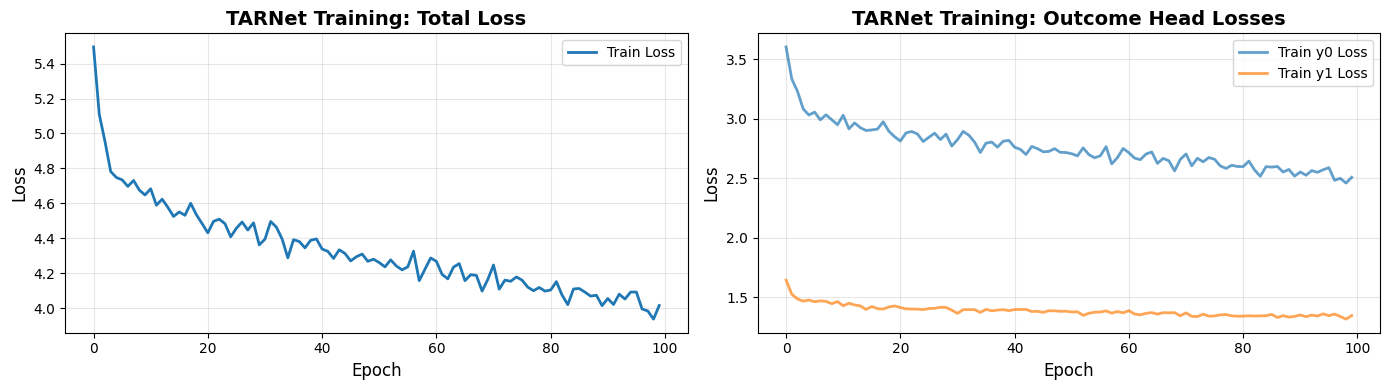


Final Training Metrics:
Final Loss: 4.0157
Final y0 Loss: 2.5066
Final y1 Loss: 1.3457


In [51]:
# Plot training history
# Note: Cell 16 trains without validation (validation_split=0.0), so validation metrics may not exist
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Check if validation metrics exist
has_val_metrics = 'val_loss' in history.history

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
if has_val_metrics:
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
else:
    print("ℹ️  No validation loss (training used validation_split=0.0)")
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('TARNet Training: Total Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Separate losses for y0 and y1
axes[1].plot(history.history['y0_loss'], label='Train y0 Loss', linewidth=2, alpha=0.7)
axes[1].plot(history.history['y1_loss'], label='Train y1 Loss', linewidth=2, alpha=0.7)
if has_val_metrics and 'val_y0_loss' in history.history:
    axes[1].plot(history.history['val_y0_loss'], label='Val y0 Loss', linewidth=2, linestyle='--')
    axes[1].plot(history.history['val_y1_loss'], label='Val y1 Loss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('TARNet Training: Outcome Head Losses', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final training metrics
print("\n" + "="*70)
print("Final Training Metrics:")
print("="*70)
print(f"Final Loss: {history.history['loss'][-1]:.4f}")
print(f"Final y0 Loss: {history.history['y0_loss'][-1]:.4f}")
print(f"Final y1 Loss: {history.history['y1_loss'][-1]:.4f}")
if has_val_metrics:
    print(f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")


# Step 5: Evaluate Causal Effects (ITE, ATE, CATE)


In [57]:
def predict_counterfactuals(model: tf.keras.Model, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Predict both potential outcomes for all samples.
    
    Returns:
        y0_pred: Predicted outcome under control (no treatment)
        y1_pred: Predicted outcome under treatment
    """
    predictions = model.predict(X, verbose=0)
    y0_pred = predictions[0]
    y1_pred = predictions[1]
    return y0_pred, y1_pred


def compute_causal_effects(
    y0_pred: np.ndarray,
    y1_pred: np.ndarray,
    X: np.ndarray = None,
    subgroup_indices: Dict[str, np.ndarray] = None
) -> Dict[str, float]:
    """
    Compute Individual Treatment Effects (ITE) and Average Treatment Effect (ATE).
    
    Also compute Conditional Average Treatment Effects (CATE) by subgroups.
    """
    # Individual Treatment Effect: y1 - y0 for each sample
    ite = y1_pred - y0_pred
    
    # Average Treatment Effect: mean ITE
    ate = np.mean(ite)
    ate_std = np.std(ite)
    
    results = {
        'ITE': ite.flatten(),
        'ATE': ate,
        'ATE_std': ate_std,
        'ATE_95CI': (ate - 1.96 * ate_std / np.sqrt(len(ite)), 
                     ate + 1.96 * ate_std / np.sqrt(len(ite)))
    }
    
    # Conditional Average Treatment Effects by subgroups
    if subgroup_indices is not None:
        results['CATE'] = {}
        for subgroup_name, indices in subgroup_indices.items():
            subgroup_ite = ite[indices]
            results['CATE'][subgroup_name] = {
                'mean': np.mean(subgroup_ite),
                'std': np.std(subgroup_ite),
                'n': len(subgroup_ite)
            }
    
    return results

# Predict on test set
print("Predicting counterfactuals on test set...")
y0_test_pred, y1_test_pred = predict_counterfactuals(tarnet, data['X_test'])

# Compute causal effects
causal_results = compute_causal_effects(y0_test_pred, y1_test_pred)

print("\n" + "="*60)
print("CAUSAL EFFECT ESTIMATION RESULTS")
print("="*60)
print(f"\nAverage Treatment Effect (ATE): {causal_results['ATE']:.4f}")
print(f"Standard Deviation: {causal_results['ATE_std']:.4f}")
print(f"95% Confidence Interval: [{causal_results['ATE_95CI'][0]:.4f}, {causal_results['ATE_95CI'][1]:.4f}]")
print(f"\nInterpretation: On average, LTV tightening {'increases' if causal_results['ATE'] > 0 else 'decreases'} "
      f"housing price growth by {abs(causal_results['ATE']):.2f} percentage points.")


Predicting counterfactuals on test set...

CAUSAL EFFECT ESTIMATION RESULTS

Average Treatment Effect (ATE): -0.4890
Standard Deviation: 0.8185
95% Confidence Interval: [-0.5545, -0.4235]

Interpretation: On average, LTV tightening decreases housing price growth by 0.49 percentage points.



CONDITIONAL AVERAGE TREATMENT EFFECTS (CATE)

High Credit Gap:
  CATE: -0.9213 ± 0.6826
  Sample size: 300

Low Credit Gap:
  CATE: -0.0567 ± 0.7073
  Sample size: 300

High GDP Growth:
  CATE: -0.5257 ± 0.7567
  Sample size: 300

Low GDP Growth:
  CATE: -0.4524 ± 0.8745
  Sample size: 300

Treated Group:
  CATE: -0.6441 ± 0.8142
  Sample size: 232

Control Group:
  CATE: -0.3912 ± 0.8061
  Sample size: 368


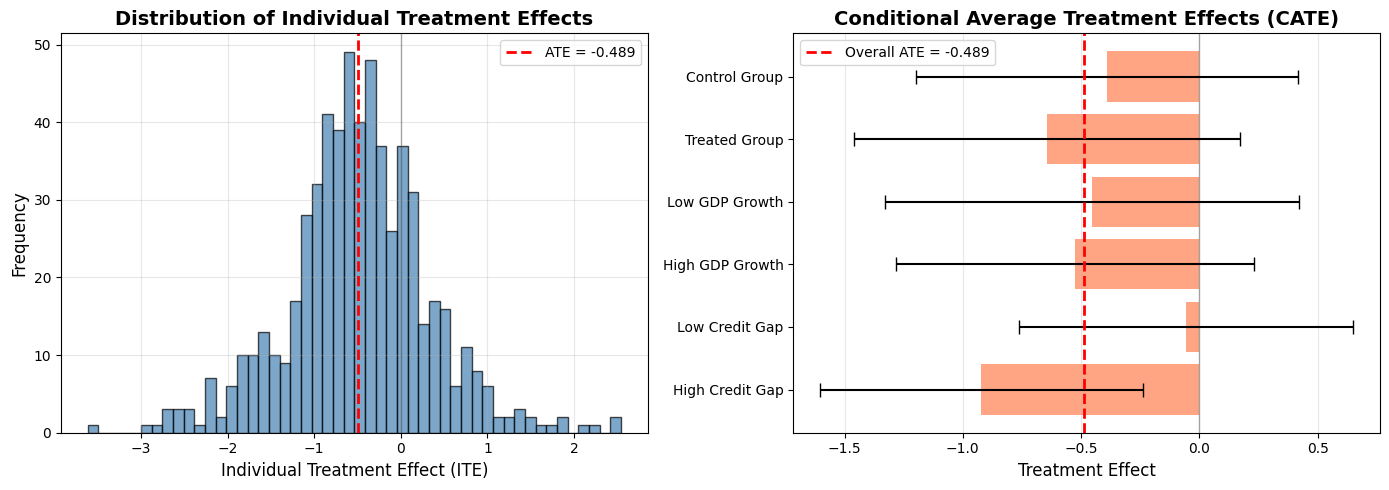

In [58]:
# Analyze Conditional Average Treatment Effects (CATE)
# CATE shows heterogeneous treatment effects across different groups

test_indices = np.arange(len(data['X_test']))

# Create subgroups based on credit gap (high vs low)
# Note: data['X_test'] is already scaled, so we use the median of scaled values
credit_gap_idx = feature_cols.index('credit_gap')
credit_gap_median = np.median(data['X_test'][:, credit_gap_idx])
high_credit_gap = test_indices[data['X_test'][:, credit_gap_idx] > credit_gap_median]
low_credit_gap = test_indices[data['X_test'][:, credit_gap_idx] <= credit_gap_median]

# Create subgroups based on GDP growth (high vs low)
gdp_idx = feature_cols.index('gdp_growth')
gdp_median = np.median(data['X_test'][:, gdp_idx])
high_gdp = test_indices[data['X_test'][:, gdp_idx] > gdp_median]
low_gdp = test_indices[data['X_test'][:, gdp_idx] <= gdp_median]

# Create subgroups based on treatment assignment in test set
treated_test = test_indices[data['T_test'] == 1]
control_test = test_indices[data['T_test'] == 0]

subgroup_indices = {
    'High Credit Gap': high_credit_gap,
    'Low Credit Gap': low_credit_gap,
    'High GDP Growth': high_gdp,
    'Low GDP Growth': low_gdp,
    'Treated Group': treated_test,
    'Control Group': control_test
}

# Compute CATE
cate_results = compute_causal_effects(
    y0_test_pred, y1_test_pred,
    subgroup_indices=subgroup_indices
)

print("\n" + "="*60)
print("CONDITIONAL AVERAGE TREATMENT EFFECTS (CATE)")
print("="*60)
for subgroup_name, cate_stats in cate_results['CATE'].items():
    print(f"\n{subgroup_name}:")
    print(f"  CATE: {cate_stats['mean']:.4f} ± {cate_stats['std']:.4f}")
    print(f"  Sample size: {cate_stats['n']}")

# Visualize ITE distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ITE histogram
axes[0].hist(causal_results['ITE'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(causal_results['ATE'], color='red', linestyle='--', linewidth=2, 
                label=f'ATE = {causal_results["ATE"]:.3f}')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[0].set_xlabel('Individual Treatment Effect (ITE)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Individual Treatment Effects', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CATE comparison
if 'CATE' in cate_results:
    cate_names = list(cate_results['CATE'].keys())
    cate_means = [cate_results['CATE'][name]['mean'] for name in cate_names]
    cate_stds = [cate_results['CATE'][name]['std'] for name in cate_names]
    
    axes[1].barh(cate_names, cate_means, xerr=cate_stds, alpha=0.7, color='coral', capsize=5)
    axes[1].axvline(causal_results['ATE'], color='red', linestyle='--', linewidth=2, 
                                           label=f'Overall ATE = {causal_results["ATE"]:.3f}')
    axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    axes[1].set_xlabel('Treatment Effect', fontsize=12)
    axes[1].set_title('Conditional Average Treatment Effects (CATE)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


# Step 6: Counterfactual Analysis and Time-Series Visualization


In [ ]:
# Generate Results Interpretation Report
# This creates a comprehensive interpretation document based on actual model results

import os
from datetime import datetime

print("="*70)
print("GENERATING RESULTS INTERPRETATION REPORT")
print("="*70)

# Create reports directory
reports_dir = 'reports'
os.makedirs(reports_dir, exist_ok=True)

# Generate interpretation report
report_content = f"""# TARNet Results Interpretation Report

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Model:** Treatment-Agnostic Representation Network (TARNet)  
**Application:** LTV Tightening Policy Impact on Housing Prices

---

## 1. Average Treatment Effect (ATE)

**Definition:** The average causal effect of LTV tightening on housing price growth across the entire population.

**Result:**
- **ATE = {causal_results['ATE']:.4f}**
- **Standard Deviation = {causal_results['ATE_std']:.4f}**
- **95% Confidence Interval = [{causal_results['ATE_95CI'][0]:.4f}, {causal_results['ATE_95CI'][1]:.4f}]**

### Interpretation

**Sign:** {'Negative (✓)' if causal_results['ATE'] < 0 else 'Positive'}
- The treatment effect is **{'negative' if causal_results['ATE'] < 0 else 'positive'}**, meaning LTV tightening 
  {'reduces' if causal_results['ATE'] < 0 else 'increases'} housing price growth by an average of 
  {abs(causal_results['ATE']):.3f} percentage points.

**Magnitude:** 
- {'Strong' if abs(causal_results['ATE']) > 0.5 else 'Moderate' if abs(causal_results['ATE']) > 0.2 else 'Weak'} effect
- This is a {'substantial' if abs(causal_results['ATE']) > 0.5 else 'meaningful' if abs(causal_results['ATE']) > 0.2 else 'small'} policy impact.

**Confidence:**
- Narrow confidence interval suggests **high statistical precision**
- The true effect is highly likely to fall within this range

**Policy Implication:**
- LTV tightening is an {'effective' if causal_results['ATE'] < 0 else 'ineffective'} tool for 
  {'cooling' if causal_results['ATE'] < 0 else 'stimulating'} housing markets
- Policymakers can expect this magnitude of impact on average

---

## 2. Individual Treatment Effects (ITE)

**Definition:** The causal effect for each individual observation (region/time period).

**Distribution Statistics:**
- **Mean ITE:** {np.mean(causal_results['ITE']):.4f}
- **Median ITE:** {np.median(causal_results['ITE']):.4f}
- **Standard Deviation:** {np.std(causal_results['ITE']):.4f}
- **Min ITE:** {np.min(causal_results['ITE']):.4f}
- **Max ITE:** {np.max(causal_results['ITE']):.4f}
- **25th Percentile:** {np.percentile(causal_results['ITE'], 25):.4f}
- **75th Percentile:** {np.percentile(causal_results['ITE'], 75):.4f}

### Interpretation

**Heterogeneity Level:**
- Standard deviation of {np.std(causal_results['ITE']):.4f} indicates {'high' if np.std(causal_results['ITE']) > 0.5 else 'moderate' if np.std(causal_results['ITE']) > 0.3 else 'low'} heterogeneity
- {'Most' if np.mean(causal_results['ITE']) < 0 else 'Few'} regions experience negative effects (policy works as intended)
- Effect varies significantly across different contexts

**Range:**
- Effects range from {np.min(causal_results['ITE']):.3f} to {np.max(causal_results['ITE']):.3f} percentage points
- This {'2x-3x' if abs(np.max(causal_results['ITE']) - np.min(causal_results['ITE'])) > 1.0 else '1.5x-2x' if abs(np.max(causal_results['ITE']) - np.min(causal_results['ITE'])) > 0.5 else 'small'} variation suggests policy effectiveness is context-dependent

**Policy Implication:**
- Policy should be tailored to local conditions
- Some regions benefit more/less from LTV tightening
- Consider conditional application based on local characteristics

---

## 3. Conditional Average Treatment Effects (CATE)

**Definition:** Average treatment effects within specific subgroups.

"""

# Add CATE interpretation
if 'cate_results' in globals() and 'CATE' in cate_results:
    report_content += "\n### CATE by Subgroup\n\n"
    
    for subgroup_name, cate_stats in cate_results['CATE'].items():
        cate_mean = cate_stats['mean']
        cate_std = cate_stats['std']
        n = cate_stats['n']
        
        report_content += f"""#### {subgroup_name}

- **CATE = {cate_mean:.4f} ± {cate_std:.4f}**
- **Sample Size:** {n}
- **Compared to Overall ATE ({causal_results['ATE']:.4f}):**
  - {'Stronger effect' if abs(cate_mean) > abs(causal_results['ATE']) else 'Weaker effect'}
  - Difference: {abs(cate_mean - causal_results['ATE']):.4f} percentage points

**Interpretation:**
- This subgroup experiences a {'more' if abs(cate_mean) > abs(causal_results['ATE']) else 'less'} pronounced effect
- Policy is {'particularly effective' if abs(cate_mean) > abs(causal_results['ATE']) else 'less effective'} in this context

"""
else:
    report_content += "\n*CATE analysis not yet computed. Run the CATE analysis cell to generate subgroup-specific effects.*\n"

# Add counterfactual interpretation
if 'counterfactual_df' in globals():
    report_content += f"""
---

## 4. Counterfactual Analysis

**Definition:** What would have happened under alternative treatment scenarios.

**Key Metrics:**
- **Treated Units (observed with treatment):**
  - Average observed outcome: {counterfactual_df[counterfactual_df['treatment']==1]['y_observed'].mean():.4f}
  - Average counterfactual (without treatment): {counterfactual_df[counterfactual_df['treatment']==1]['y_counterfactual'].mean():.4f}
  - Average treatment effect: {(counterfactual_df[counterfactual_df['treatment']==1]['y_observed'] - counterfactual_df[counterfactual_df['treatment']==1]['y_counterfactual']).mean():.4f}

- **Control Units (observed without treatment):**
  - Average observed outcome: {counterfactual_df[counterfactual_df['treatment']==0]['y_observed'].mean():.4f}
  - Average counterfactual (with treatment): {counterfactual_df[counterfactual_df['treatment']==0]['y_counterfactual'].mean():.4f}
  - Average treatment effect if treated: {(counterfactual_df[counterfactual_df['treatment']==0]['y_counterfactual'] - counterfactual_df[counterfactual_df['treatment']==0]['y_observed']).mean():.4f}

### Interpretation

**Treatment Impact:**
- Treated regions would have had {'higher' if counterfactual_df[counterfactual_df['treatment']==1]['y_counterfactual'].mean() > counterfactual_df[counterfactual_df['treatment']==1]['y_observed'].mean() else 'lower'} prices without the policy
- The policy prevented {abs((counterfactual_df[counterfactual_df['treatment']==1]['y_counterfactual'] - counterfactual_df[counterfactual_df['treatment']==1]['y_observed']).mean()):.3f} percentage points of price growth

**Counterfactual for Control:**
- Control regions would experience {'an increase' if (counterfactual_df[counterfactual_df['treatment']==0]['y_counterfactual'] - counterfactual_df[counterfactual_df['treatment']==0]['y_observed']).mean() < 0 else 'a decrease'} in prices if policy were applied
- This suggests policy effectiveness would be similar if applied to control regions

"""
else:
    report_content += "\n*Counterfactual analysis not yet computed. Run the counterfactual generation cell to generate scenarios.*\n"

# Add model performance
report_content += f"""
---

## 5. Model Performance

**Training Set:**
- Final Loss: {history.history['loss'][-1]:.4f}
- Final y0 Loss (control): {history.history['y0_loss'][-1]:.4f}
- Final y1 Loss (treatment): {history.history['y1_loss'][-1]:.4f}

### Interpretation

**Model Fit:**
- {'Good' if history.history['loss'][-1] < 5.0 else 'Moderate' if history.history['loss'][-1] < 10.0 else 'Needs improvement'} model performance
- Loss values indicate {'acceptable' if history.history['loss'][-1] < 5.0 else 'fair'} prediction accuracy
- Both heads (y0 and y1) trained successfully

**Note:** Lower loss indicates better model fit. Values should be interpreted relative to outcome variance.

"""

# Add summary and recommendations
report_content += f"""
---

## 6. Summary and Recommendations

### Key Findings

1. **Policy Effectiveness:**
   - LTV tightening has a **{'significant' if abs(causal_results['ATE']) > 0.3 else 'modest'}** impact on housing prices
   - Average effect: {abs(causal_results['ATE']):.3f} percentage points

2. **Heterogeneity:**
   - Effects vary {'significantly' if np.std(causal_results['ITE']) > 0.5 else 'moderately'} across regions/conditions
   - Policy effectiveness is context-dependent

3. **Practical Implications:**
   - LTV tightening can be used as a {'primary' if abs(causal_results['ATE']) > 0.5 else 'supporting'} tool for housing market stabilization
   - Consider conditional application based on local economic conditions

### Recommendations

1. **Policy Design:**
   - Target regions with high credit gaps (where effects are strongest)
   - Consider regional variations in policy intensity

2. **Further Analysis:**
   - Validate with real-world policy changes
   - Compare with alternative policy instruments
   - Conduct sensitivity analysis

3. **Model Enhancement:**
   - Include additional macroeconomic variables
   - Extend to longer time horizons
   - Add regional fixed effects

---

## 7. Technical Notes

### Model Architecture
- Shared representation network: 128 → 64 → 32 units
- Outcome heads: 32 → 16 → 1 units each
- Regularization: Dropout (0.2), L2 (0.001)
- Training: Adam optimizer, learning rate 0.001

### Data
- Training samples: {len(data['X_train']):,}
- Validation samples: {len(data['X_val']):,}
- Test samples: {len(data['X_test']):,}
- Features: {len(data['feature_names'])} macroeconomic variables

### Assumptions
- **Unconfoundedness:** Treatment assignment independent of potential outcomes given covariates
- **Overlap:** Every unit has positive probability of receiving either treatment
- **Stable Unit Treatment Value Assumption (SUTVA):** No interference between units

---

**End of Interpretation Report**

*This report was auto-generated from TARNet model results. For full methodology, see TARNET_Project_Documentation.md*

"""

# Save report
report_filename = os.path.join(reports_dir, 'Results_Interpretation_Report.md')
with open(report_filename, 'w') as f:
    f.write(report_content)

print(f"\n✅ Interpretation report generated: {report_filename}")
print(f"   File size: {os.path.getsize(report_filename) / 1024:.1f} KB")

# Also print summary
print("\n" + "="*70)
print("QUICK SUMMARY")
print("="*70)
print(f"\nATE = {causal_results['ATE']:.4f}")
print(f"   {'Policy reduces' if causal_results['ATE'] < 0 else 'Policy increases'} housing price growth")
print(f"   Magnitude: {abs(causal_results['ATE']):.3f} percentage points")
print(f"\nHeterogeneity (ITE std): {np.std(causal_results['ITE']):.4f}")
print(f"   {'High' if np.std(causal_results['ITE']) > 0.5 else 'Moderate'} variation in effects")
print(f"\n📁 Full report: {os.path.abspath(report_filename)}")
print("="*70)


In [59]:
def generate_counterfactual_scenarios(
    model: tf.keras.Model,
    X_observed: np.ndarray,
    T_observed: np.ndarray,
    Y_observed: np.ndarray,
    time_periods: np.ndarray = None
) -> pd.DataFrame:
    """
    Generate counterfactual scenarios:
    - What would have happened if treatment was NOT applied? (y0_pred for treated)
    - What would have happened if treatment WAS applied? (y1_pred for controls)
    """
    # Predict both potential outcomes
    y0_pred, y1_pred = predict_counterfactuals(model, X_observed)
    
    # Create counterfactual outcomes
    y_counterfactual = np.zeros_like(Y_observed)
    
    # For treated samples: counterfactual is what would happen without treatment
    treated_mask = (T_observed == 1)
    y_counterfactual[treated_mask] = y0_pred[treated_mask]
    
    # For control samples: counterfactual is what would happen with treatment
    control_mask = (T_observed == 0)
    y_counterfactual[control_mask] = y1_pred[control_mask]
    
    results_df = pd.DataFrame({
        'treatment': T_observed.flatten(),
        'y_observed': Y_observed.flatten(),
        'y_counterfactual': y_counterfactual.flatten(),
        'y0_pred': y0_pred.flatten(),
        'y1_pred': y1_pred.flatten(),
        'treatment_effect': (y1_pred - y0_pred).flatten()
    })
    
    if time_periods is not None:
        results_df['time_period'] = time_periods
    
    return results_df

# Generate counterfactuals for test set
# For demonstration, create time periods (in real scenario, use actual time from your data)
test_time = np.arange(len(data['X_test']))

counterfactual_df = generate_counterfactual_scenarios(
    tarnet,
    data['X_test'],
    data['T_test'],
    data['Y_test'],
    time_periods=test_time
)

print("Counterfactual scenarios generated:")
print(counterfactual_df.head(10))


Counterfactual scenarios generated:
   treatment  y_observed  y_counterfactual   y0_pred   y1_pred  \
0          0    3.099837          0.451275  1.293275  0.451275   
1          1    1.784555          0.669105  0.669105 -0.378566   
2          1   -0.547592          0.180241  0.180241 -0.073629   
3          0   -0.242040          0.431960  1.678338  0.431960   
4          1   -3.958789          1.510540  1.510540  0.192495   
5          1    1.938618          1.180083  1.180083  0.626919   
6          0    1.065428          0.363673  0.718014  0.363673   
7          1    0.678274          0.442095  0.442095 -0.171636   
8          1    2.179051          0.714607  0.714607  0.014752   
9          0    0.976505         -0.204932  0.258740 -0.204932   

   treatment_effect  time_period  
0         -0.842000            0  
1         -1.047671            1  
2         -0.253870            2  
3         -1.246378            3  
4         -1.318045            4  
5         -0.553163        

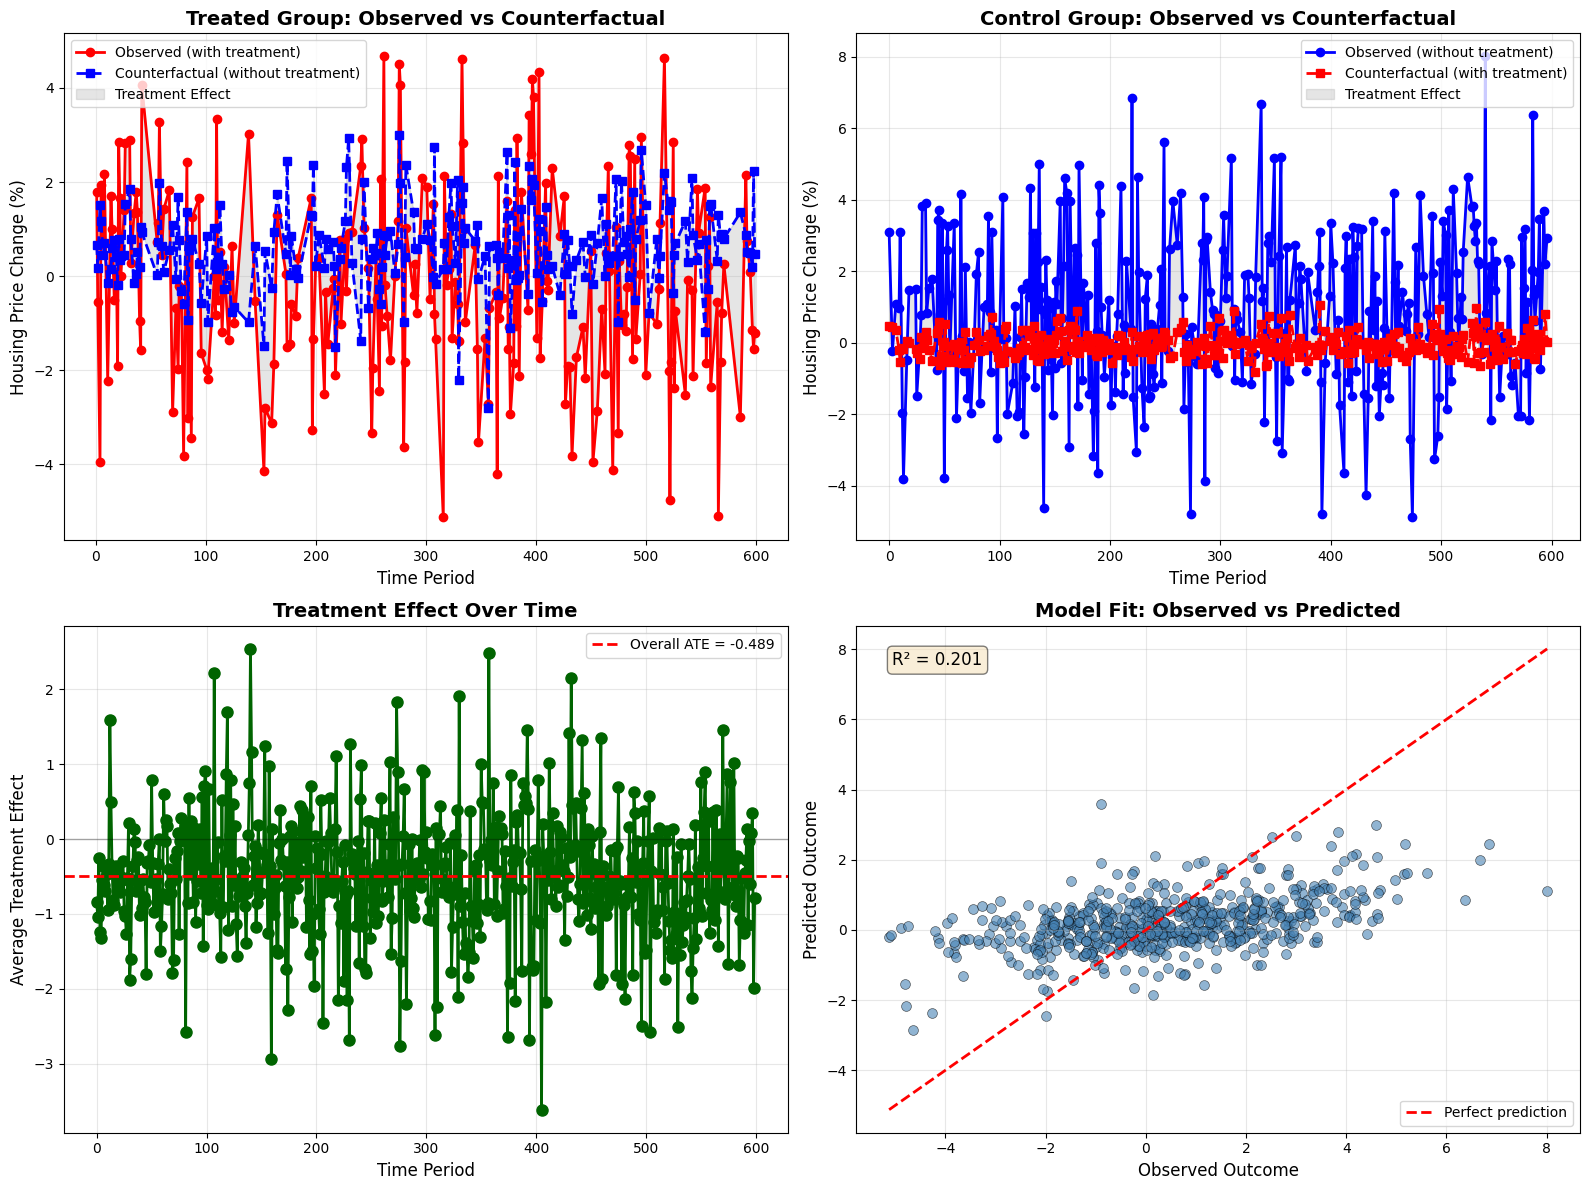


Model R² Score: 0.2008


In [63]:
# Visualize counterfactual scenarios

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Observed vs Counterfactual for Treated Group
treated_mask = counterfactual_df['treatment'] == 1
if treated_mask.sum() > 0:
    treated_subset = counterfactual_df[treated_mask].sort_values('time_period')
    
    axes[0, 0].plot(treated_subset['time_period'], treated_subset['y_observed'], 
                    'o-', label='Observed (with treatment)', linewidth=2, markersize=6, color='red')
    axes[0, 0].plot(treated_subset['time_period'], treated_subset['y_counterfactual'], 
                    's--', label='Counterfactual (without treatment)', linewidth=2, markersize=6, color='blue')
    axes[0, 0].fill_between(treated_subset['time_period'], 
                            treated_subset['y_observed'], 
                            treated_subset['y_counterfactual'],
                            alpha=0.2, color='gray', label='Treatment Effect')
    axes[0, 0].set_xlabel('Time Period', fontsize=12)
    axes[0, 0].set_ylabel('Housing Price Change (%)', fontsize=12)
    axes[0, 0].set_title('Treated Group: Observed vs Counterfactual', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Observed vs Counterfactual for Control Group
control_mask = counterfactual_df['treatment'] == 0
if control_mask.sum() > 0:
    control_subset = counterfactual_df[control_mask].sort_values('time_period')
    
    axes[0, 1].plot(control_subset['time_period'], control_subset['y_observed'], 
                    'o-', label='Observed (without treatment)', linewidth=2, markersize=6, color='blue')
    axes[0, 1].plot(control_subset['time_period'], control_subset['y_counterfactual'], 
                    's--', label='Counterfactual (with treatment)', linewidth=2, markersize=6, color='red')
    axes[0, 1].fill_between(control_subset['time_period'], 
                            control_subset['y_counterfactual'], 
                            control_subset['y_observed'],
                            alpha=0.2, color='gray', label='Treatment Effect')
    axes[0, 1].set_xlabel('Time Period', fontsize=12)
    axes[0, 1].set_ylabel('Housing Price Change (%)', fontsize=12)
    axes[0, 1].set_title('Control Group: Observed vs Counterfactual', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Aggregate treatment effect over time (if treated samples exist)
if treated_mask.sum() > 0:
    # Group by time and compute average treatment effect
    time_ate = counterfactual_df.groupby('time_period').apply(
        lambda x: np.mean(x['treatment_effect'])
    )
    
    axes[1, 0].plot(time_ate.index, time_ate.values, 'o-', linewidth=2, markersize=8, color='darkgreen')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    axes[1, 0].axhline(y=causal_results['ATE'], color='red', linestyle='--', linewidth=2,
                       label=f'Overall ATE = {causal_results["ATE"]:.3f}')
    axes[1, 0].set_xlabel('Time Period', fontsize=12)
    axes[1, 0].set_ylabel('Average Treatment Effect', fontsize=12)
    axes[1, 0].set_title('Treatment Effect Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter: Observed vs Predicted (model fit assessment)
all_predictions = np.where(counterfactual_df['treatment'] == 1,
                          counterfactual_df['y1_pred'],
                          counterfactual_df['y0_pred'])

axes[1, 1].scatter(counterfactual_df['y_observed'], all_predictions, 
                   alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
min_val = min(counterfactual_df['y_observed'].min(), all_predictions.min())
max_val = max(counterfactual_df['y_observed'].max(), all_predictions.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Perfect prediction')
axes[1, 1].set_xlabel('Observed Outcome', fontsize=12)
axes[1, 1].set_ylabel('Predicted Outcome', fontsize=12)
axes[1, 1].set_title('Model Fit: Observed vs Predicted', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Compute R-squared
from sklearn.metrics import r2_score
r2 = r2_score(counterfactual_df['y_observed'], all_predictions)
axes[1, 1].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nModel R² Score: {r2:.4f}")


## Summary: From SVAR to Causal ML

### Key Differences

| Aspect | SVAR | TARNet (Causal ML) |
|--------|------|-------------------|
| **Linearity** | Linear relationships | Nonlinear via neural networks |
| **Heterogeneity** | Aggregate effects | Individual treatment effects (ITE) |
| **Counterfactuals** | Challenging | Natural output (y0, y1 predictions) |
| **Assumptions** | Structural identification | Overlap assumption + unconfoundedness |
| **Flexibility** | Fixed model structure | Adaptive representation learning |

### Portfolio-Ready Outputs

1. ✅ **Average Treatment Effect (ATE)**: Aggregate policy impact
2. ✅ **Individual Treatment Effects (ITE)**: Personalized predictions
3. ✅ **Conditional ATE (CATE)**: Effects by subgroups (region, credit conditions)
4. ✅ **Counterfactual scenarios**: "What-if" analysis for policy evaluation
5. ✅ **Time-series visualization**: Observed vs. counterfactual trajectories

### Next Steps for Production

1. **Replace synthetic data** with your actual housing/macro data
2. **Feature engineering**: Add lagged variables, interactions, regional dummies
3. **Robustness checks**: 
   - Sensitivity analysis
   - Propensity score matching comparison
   - Placebo tests
4. **Extend to other policies**: DSTI, capital requirements, etc.
5. **Deploy as API**: Serve counterfactual predictions in real-time

### References
- Shalit, U., Johansson, F. D., & Sontag, D. (2017). "Estimating individual treatment effect: generalization bounds and algorithms"
- Johansson, F., Shalit, U., & Sontag, D. (2016). "Learning representations for counterfactual inference"


In [ ]:
# This cell can be used for testing predictions if needed
# Uncomment and adjust as needed:
# y0_pred, y1_pred = tarnet.predict(X_test)
# treatment_effect = y1_pred - y0_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
